In [33]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import autograd.numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg as LA
# from numpy import linalg as LA
# from pyblas.level1 import dnrm2

sys.path.insert(0, os.path.join(".."))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

In [3]:
plt.rcParams['figure.figsize'] = 15, 8
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

# MDP

In [4]:
sys.path.insert(0, os.path.join("..", "tdlearn"))

In [5]:
sys.path.insert(0, os.path.join("..", "tdlearn", "util"))

In [6]:
# repo from https://github.com/chrodan/tdlearn
from tdlearn import examples
from tdlearn import features
from tdlearn import policies

In [7]:
n = 400 # |S|
n_a = 10
n_feat = 200 # d
mdp = examples.RandomMDP(n, n_a)
phi = features.lin_random(n_feat, n, constant=True)
gamma = .95
np.random.seed(3)
beh_pol = policies.Discrete(np.random.rand(n, n_a))
tar_pol = policies.Discrete(np.random.rand(n, n_a))

In [8]:
from task import LinearDiscreteValuePredictionTask

task = LinearDiscreteValuePredictionTask(mdp, gamma, phi, np.zeros(phi.dim),
                                         policy=beh_pol, target_policy=tar_pol)

In [9]:
Phi = task.Phi

### Check the equal methods of multidim dot

In [ ]:
_C = np.zeros((n_feat, n_feat))
for s in range(n):
    _C += Phi[s].T.dot(Phi[s])

In [ ]:
_C

array([[132.3901114 ,  97.76274183, 102.33712169, ..., 101.92788541,
         97.90852101, 198.62850564],
       [ 97.76274183, 133.84740882, 105.41928405, ..., 103.89166623,
        101.36922797, 199.80451165],
       [102.33712169, 105.41928405, 140.99246525, ..., 106.10621796,
        107.04401561, 207.82468526],
       ...,
       [101.92788541, 103.89166623, 106.10621796, ..., 138.4972571 ,
        103.59722151, 203.98860115],
       [ 97.90852101, 101.36922797, 107.04401561, ..., 103.59722151,
        138.57030077, 204.7450469 ],
       [198.62850564, 199.80451165, 207.82468526, ..., 203.98860115,
        204.7450469 , 400.        ]])

In [ ]:
C = np.tensordot(Phi[:, None, :], Phi[..., None], axes=([0,1], [0,2]))

In [ ]:
np.isclose(C,_C).all()

True

### Experiment setting

In [10]:
_states, _actions, _n_states, _rewards = [], [], [], []
N = 20000
for s, a, _s, r in task.mdp.sample_transition(max_n=N, policy=beh_pol, seed=None,
                                              with_restart=True, s_start=None):
    _states.append(s)
    _actions.append(a)
    _n_states.append(_s)
    _rewards.append(r)

In [11]:
C = np.tensordot(Phi[_states, None, :], Phi[_states, :, None], axes=([0,1], [0,2]))

In [12]:
b = np.asarray(np.array(_rewards).dot(Phi[_states, :]))

In [13]:
B = C - gamma*np.tensordot(Phi[_states, None, :], 
                           Phi[np.hstack([_states[1:], _states[-1]]), :, None], axes=([0,1], [0,2]))

In [14]:
import lib.utils as ut


class RL_problem(pr.BaseSaddle):
    def __init__(self, B, C, b, rho=1., proj_x=None, proj_y=None):
        L_xy = 1
        mu_xy = 0.25
        mu_yx = 0.25
        A = -B
        super().__init__(A=A)
        self.A = A
        spectrum = LA.svdvals(self.A.T.dot(self.A))
        self.L_xy = spectrum[0]**.5
        self.mu_yx = spectrum[-1]**.5 
        self.mu_xy = LA.svdvals(self.A.dot(self.A.T))[-1]**.5
        self.C = (C + C.T)/2
        spectrum = LA.eigvalsh(self.C)
        self.L_y = spectrum.max()
        self.mu_y = spectrum.real.min()
        if np.isclose(self.mu_y, 0.):
            self.mu_y = 0.
        print("C", self.L_y, self.mu_y)
        # self.C_inv = LA.inv(self.C)
        self.b = b
        n = self.A.shape[0]
        
        self.rho = rho
        self.f = lambda x: self.rho*0.5*x.transpose() @ x
        self.g = lambda y:  0.5*y.transpose() @ self.C @ y - self.b.transpose().squeeze() @ y
        self.L_x = self.rho
        self.mu_x = self.rho
        self.L = max(self.L_xy, self.L_x, self.L_y)
        
        
        if self.rho == 0:
            self.yopt = LA.solve(self.A.transpose(), np.zeros((n, 1)),
                                 check_finite=True, assume_a='sym') 
            self.xopt = LA.solve(self.A, self.C.dot(self.yopt) - self.b,
                                 check_finite=True, assume_a='sym')
        else:
            matrix = self.C + 1/self.rho*self.A @ self.A.T
            try:
                self.yopt = LA.solve(matrix, self.b,
                                     check_finite=True, assume_a='sym') 
            except LA.LinAlgError:
                self.yopt = LA.lstsq(matrix, self.b, check_finite=True)[0]
            self.xopt =  -1/self.rho * self.A.T.dot(self.yopt)
            
        self.constraint=False   
        self.grad_f = grad(self.f)
        self.grad_g = grad(self.g)  
        self.d2fdxdx = grad(self.grad_f)
        self.F = lambda x, y: self.f(x) + y.T @ self.A @ x - self.g(y)
        self.dFdx = grad(self.F)
        self.dFdy = grad(self.F, 1)
        self._proj_x = proj_x
        self._proj_y = proj_y
        self.proj_x = lambda x: x if proj_x is None else proj_x(x)
        self.proj_y = lambda x: x if proj_y is None else proj_y(x)
        
    # def MSPBE_loss(self, x, y):
    #     return 0.5 * ((self.A.dot(x) - self.b.squeeze()).T.dot(self.C_inv).dot(self.A.dot(x) - self.b.squeeze()))
    
    def primal_func(self, x, y=None):
        """
        Computes the function value
        f_max(x) = \max_y F(x, y)
  
        F(x, y) = f(x) + <y, Ax> - g(y)
        f(x) = rho 0.5 <x, x>
        g(y) = -0.5 <y, Cy> + <b, y>
        Args:
            x: np.array([dx])
        Returns:
            f_max(x): real function value
        """
        matrix = self.C
        vector = self.A.dot(x) + self.b.squeeze()

        try:
            y_max = LA.solve(matrix, vector, check_finite=True, assume_a='sym')
        except LA.LinAlgError:
            y_max = LA.lstsq(matrix, vector, check_finite=True)[0]

        return self.F(x, y_max)

    def dual_func(self, y, x=None, func_lb=None):
        """
        Computes the function value
        g_min(y) = \min_x F(x, y)
  
        F(x, y) = f(x) + <y, Ax> - g(y)
        f(x) = 0.5 rho <x, x>
        g(y) = -0.5 <y, Cy> + <b, y>
        Args:
            y: np.array([dy])
        Returns:
            h_min(y): real function value
        """
        matrix = self.rho * np.eye(x.shape[0])
        vector = -self.A.T.dot(y)
        try:
            x_min = scipy.linalg.solve(matrix, vector, check_finite=True, assume_a='sym')
        except scipy.linalg.LinAlgError:
            x_min = scipy.linalg.lstsq(matrix, vector, check_finite=True)[0]
          
        return self.F(x_min, y)

In [15]:
A=B
n_feat=200
RHO = LA.svd(A.T.dot(LA.inv(C)).dot(A))[1].max()
# RHO = 1.
problem_RL = RL_problem(B=B,C=C, b=b.T, rho=RHO)
L = max(problem_RL.L_x, problem_RL.L_y, problem_RL.L_xy)
params = {"apdg": None,
          "lpd": None,
          'altgd': None,
          'simgd': None,
          # 'avg': {"lr": 1 / (2*L)},
          'eg': None,
          'omd': None,
          'AA': None,
          'smm': None
         }
 # {'adam':0.01,'fr':0.05,}

x0 = np.ones(n_feat, )
y0 = np.ones(n_feat, )
type2=True
iteration = 10000
k =  100
methods_dict = ut.main(problem_RL, iteration, x0.copy(), y0.copy(), params)

C 1018186.56226474 6.11292775973797


LPD: 100%|███████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 139.33it/s]


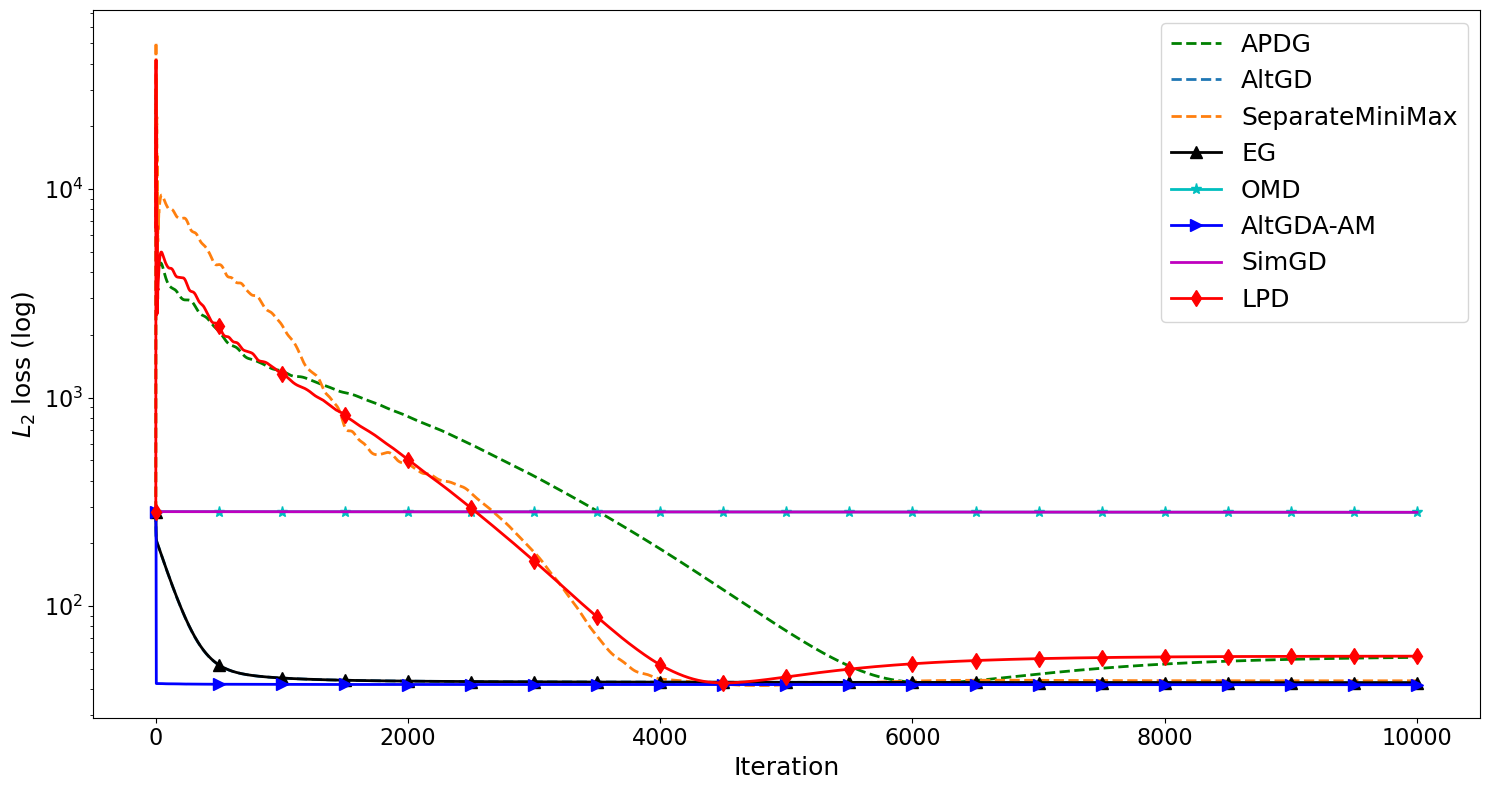

In [21]:
%matplotlib inline
plot_interval = 1
markevery=500
for method in methods_dict:
    if method not in []:
        plt.semilogy(np.arange(0, iteration+plot_interval, plot_interval),
                     methods_dict[method]["loss_hist"][::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel(r"$L_2$ loss (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"MDP_loss_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"MDP_loss_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

APDG 146475128.66832146
AltGD 146475128.66832146
SeparateMiniMax 146475128.66832146
EG 146475128.66832146
OMD 146475128.66832146
AltGDA-AM 146475128.66832146
SimGD 146475128.66832146
LPD 146475128.66832146


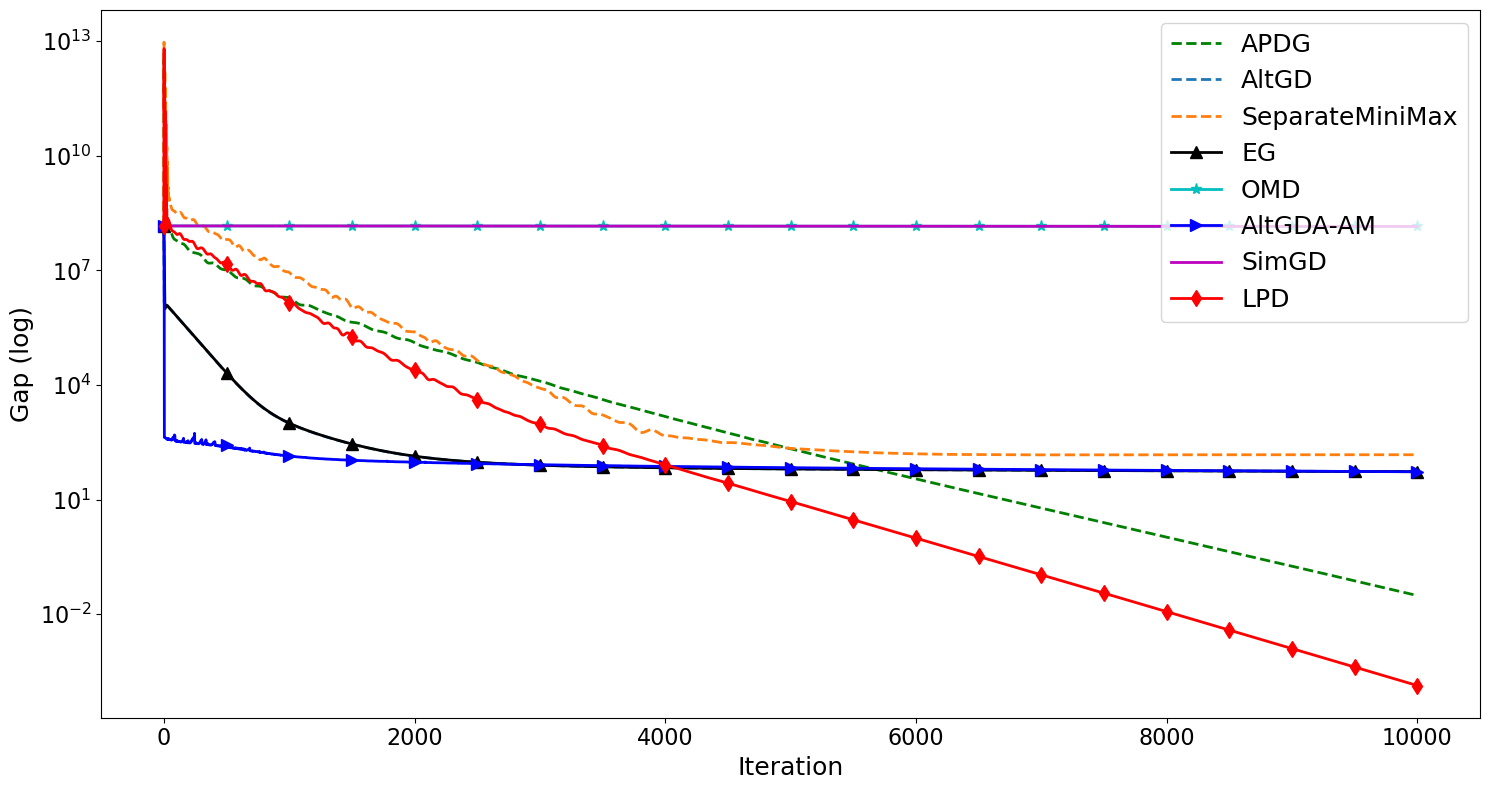

In [18]:
plot_interval = 1
markevery=500
for method in methods_dict:
    if method not in []:
        _gap =methods_dict[method]["class"].all_metrics["gap"]
        print(method, _gap[0])
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"MDP_gap_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"MDP_gap_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

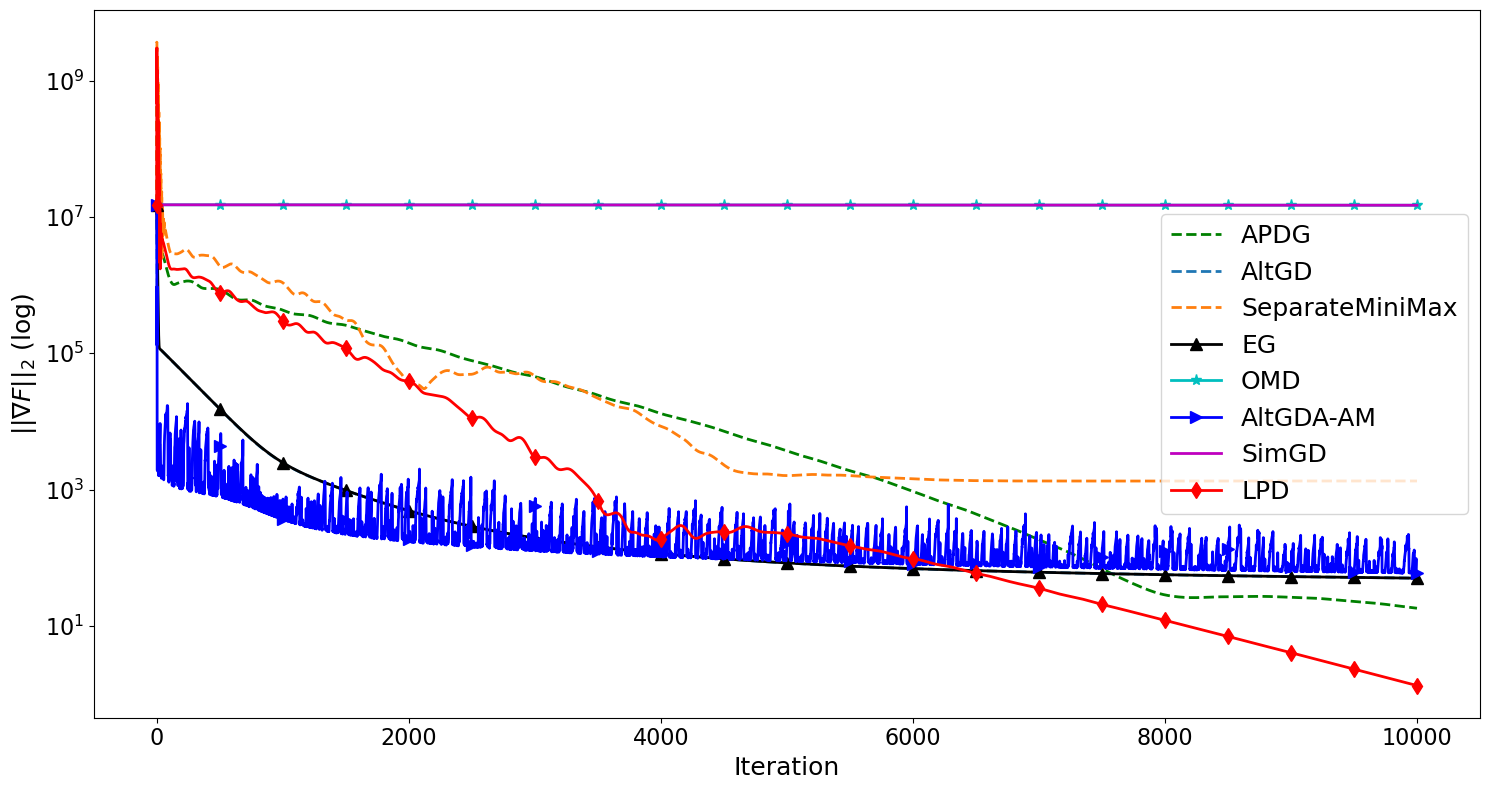

In [19]:
plot_interval = 1
markevery=500
for method in methods_dict:
    if method not in []:
        _gap =methods_dict[method]["class"].all_metrics["grad_norm"]
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel(r"$||\nabla F||_2$ (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"MDP_grad_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"MDP_grad_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

In [349]:
ut.display_constants(problem_RL)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [83]:
problem_RL.MSPBE_loss(methods_dict["APDG"]["class"].x,
                      methods_dict["APDG"]["class"].y
                     )

4013.447678673696

# MountainCar
Data is taken from https://github.com/tkkiran/LiftedPrimalDual/tree/main/mountaincar_data

In [22]:
import pandas as pd

In [23]:
state = pd.read_csv(os.path.join("..", "data", 'mountaincar_data', 'state.csv'),
                    delimiter=',', header=None).to_numpy().T#[:, :5000]
reward = pd.read_csv(os.path.join("..", "data", 'mountaincar_data', 'reward.csv'),
                     delimiter=',', header=None).to_numpy()#[:5000, :]
next_state = pd.read_csv(os.path.join("..", "data", 'mountaincar_data', 'nextstate.csv'),
                         delimiter=',', header=None).to_numpy().T#[:, :5000]

In [24]:
GAMMA = 0.95
Phi_Mountain = state
Phi_next = next_state

Phi_gamma_phi_next = Phi_Mountain - GAMMA * Phi_next
reward_phi = Phi_Mountain.dot(reward)

In [25]:
n = Phi_Mountain.shape[-1]
A = Phi_Mountain.dot(Phi_gamma_phi_next.T)/n
b = reward_phi/n
C = Phi_Mountain.dot(Phi_Mountain.T)/n

In [28]:
import numpy.linalg as LA
LA.matrix_rank(C)

204

## Mountain car with PCA (SC-C trick to SC-SC...)

In [29]:
from sklearn import decomposition
from scipy import linalg as LA

pca = decomposition.PCA(n_components=200, copy=False)
state_pca = pca.fit_transform(state.T).T
next_state_pca = pca.transform(next_state.T).T

In [30]:
reward_pca = reward
next_state = next_state_pca
phi_pca = state_pca
phi_next_pca = next_state_pca

phi_gamma_phi_next_pca = phi_pca - gamma*phi_next_pca
reward_phi_pca = phi_pca.dot(reward_pca)

n_pca = phi_pca.shape[-1]
A_pca = phi_pca.dot(phi_gamma_phi_next_pca.T)/n_pca
b_pca = reward_phi_pca/n_pca
C_pca = phi_pca.dot(phi_pca.T)/n_pca

In [31]:
d = C_pca.shape[0]

rho = 1.0
# B = rho*np.eye(C.shape[0])

In [34]:
n_feat = d

problem_RL_2 = RL_problem(B=-A_pca, C=C_pca, b=b_pca, rho=rho)
L = max(problem_RL_2.L_x, problem_RL_2.L_y, problem_RL_2.L_xy)
params = {"apdg": None,
          "lpd": None,
          'altgd': None,
          'simgd': None,
          # 'avg': {"lr": 1 / (2*L)},
          'eg': None,
          'omd': None,
          'AA': None, 
          'smm': None
         }
 # {'adam':0.01,'fr':0.05,}

x0 = np.ones(n_feat, )
y0 = np.ones(n_feat, )

iteration = 10000

methods_dict_2 = ut.main(problem_RL_2, iteration, x0.copy(), y0.copy(), params)

C 0.3692031335996455 1.904377777518091e-05


LPD:  43%|████████████████████████████████████▎                                               | 4323/10000 [00:38<00:50, 111.37it/s]


In [35]:
ut.display_constants(problem_RL_2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

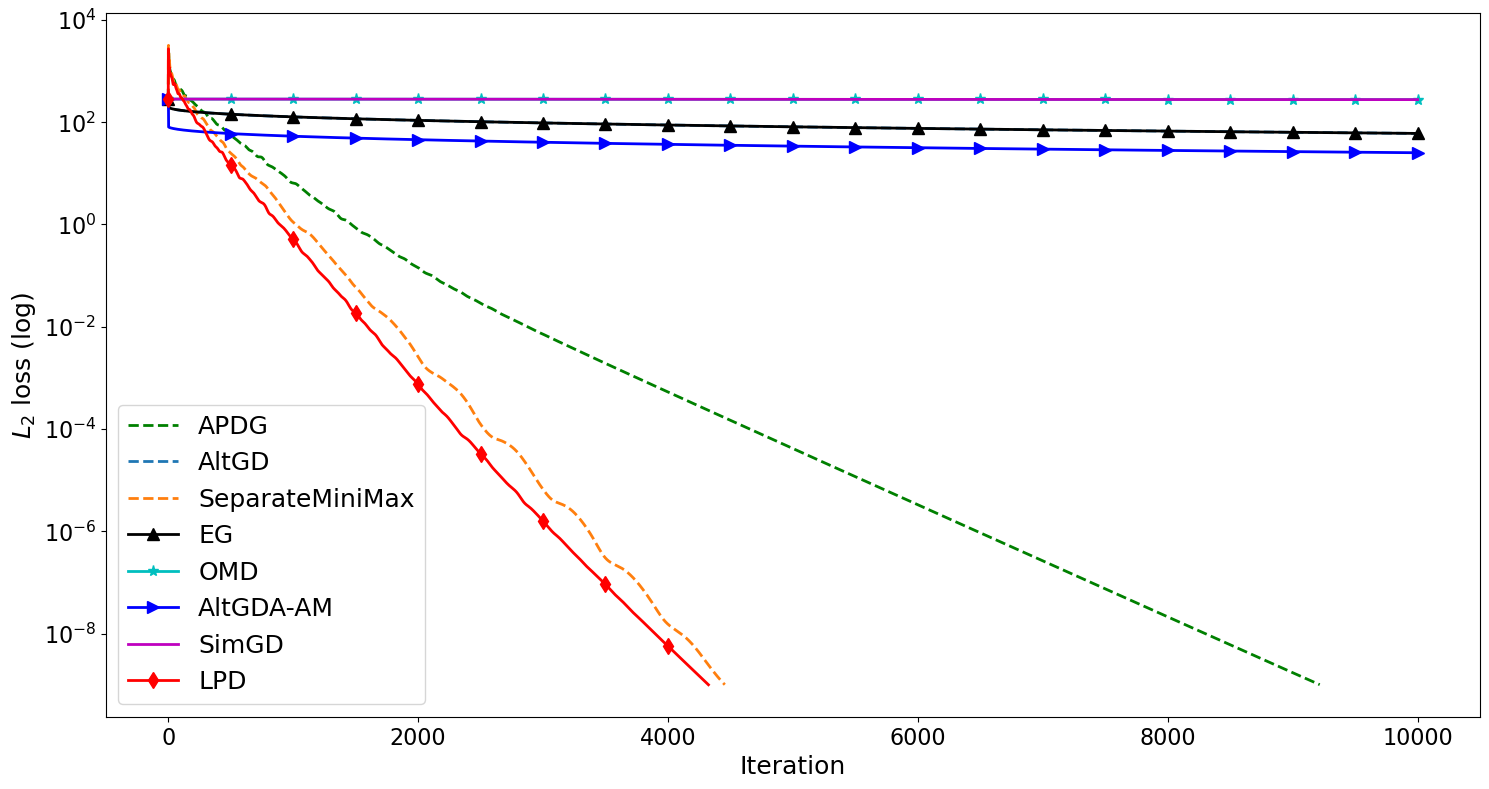

In [37]:
%matplotlib inline
plot_interval = 1
markevery=500
for method in methods_dict_2:
    if method not in []:
        plt.semilogy(np.arange(0, len(methods_dict_2[method]["loss_hist"])+plot_interval-1, plot_interval),
                     methods_dict_2[method]["loss_hist"][::plot_interval],
                     methods_dict_2[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel(r"$L_2$ loss (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"MountainCar_loss_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"MountainCar_loss_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

APDG 102.24746170618249
AltGD 102.24746170618249
SeparateMiniMax 102.24746170618249
EG 102.24746170618249
OMD 102.24746170618249
AltGDA-AM 102.24746170618249
SimGD 102.24746170618249
LPD 102.24746170618249


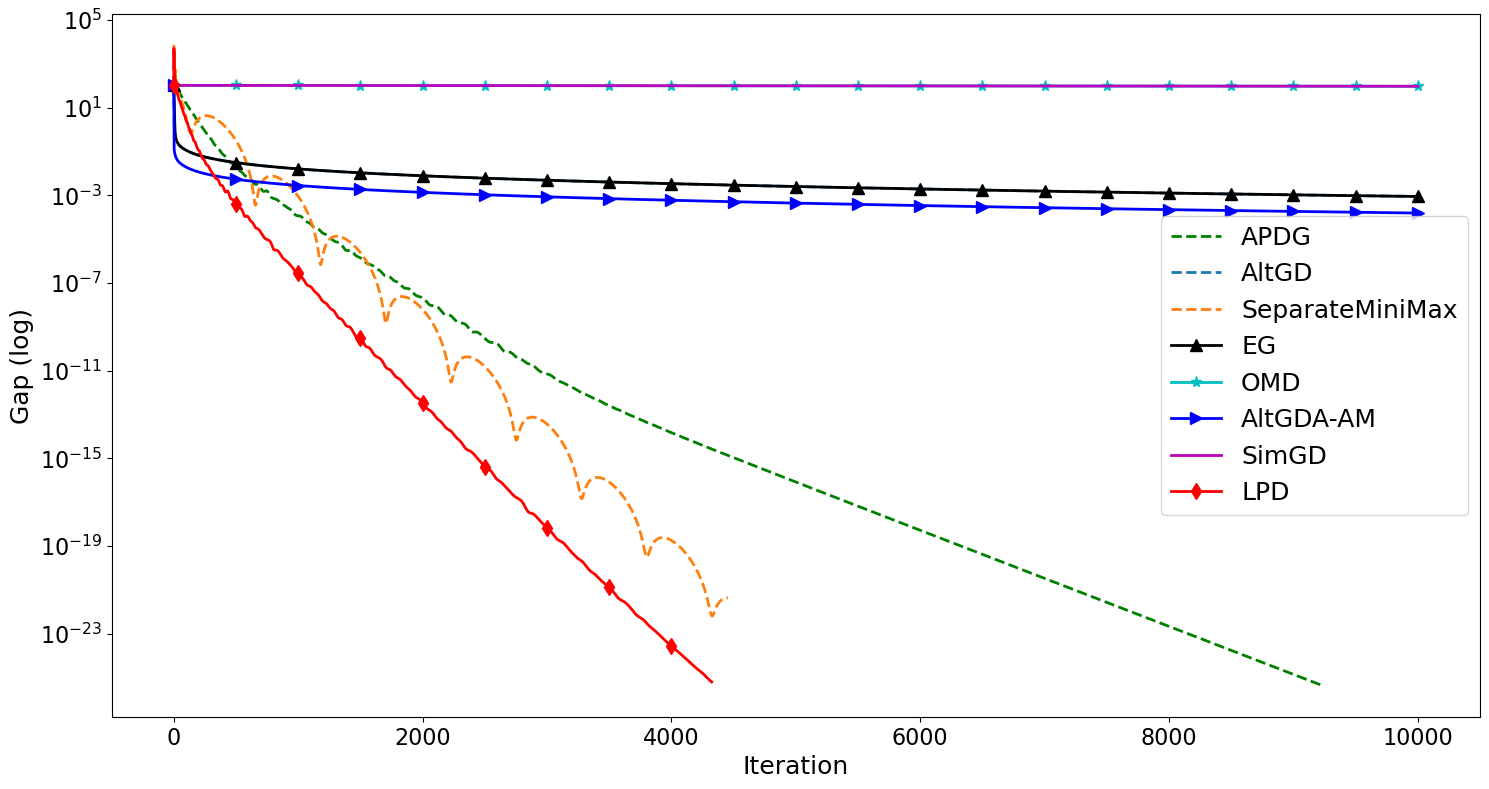

In [38]:
plot_interval = 1
markevery=500
for method in methods_dict_2:
    if method not in []:
        _gap =methods_dict_2[method]["class"].all_metrics["gap"]
        print(method, _gap[0])
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict_2[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"MountainCar_gap_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"MountainCar_gap_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

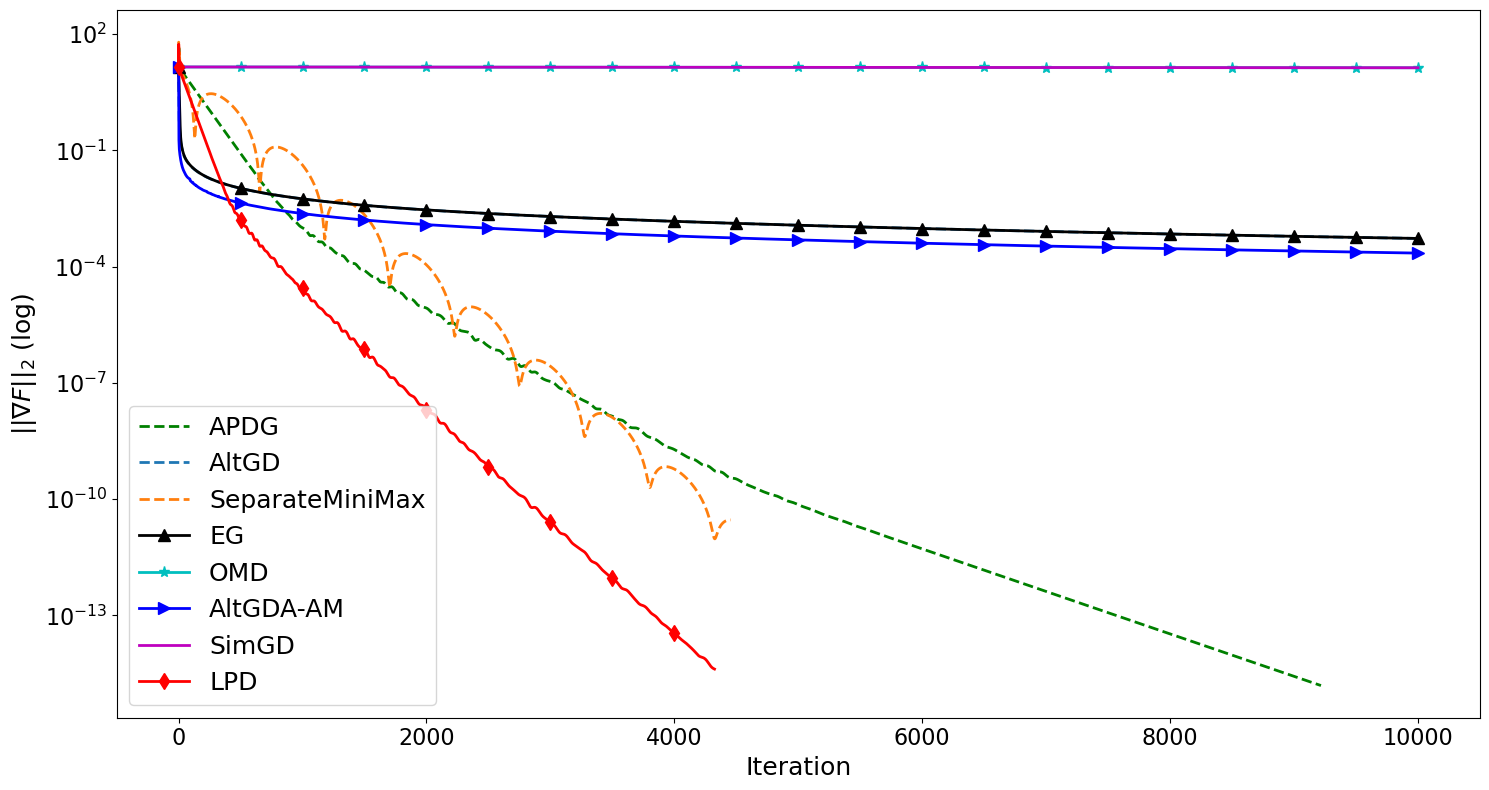

In [39]:
plot_interval = 1
markevery=500
for method in methods_dict_2:
    if method not in []:
        _gap =methods_dict_2[method]["class"].all_metrics["grad_norm"]
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict_2[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel(r"$||\nabla F||_2$ (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"MountainCar_grad_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"MountainCar_grad_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

# MountainCar SC-C problem

In [43]:
B.shape

(300, 300)

In [44]:
C.shape

(300, 300)

In [45]:
b.shape

(300, 1)

In [50]:
d = 300

rho = 1.0
B = rho*np.eye(C.shape[0])

D = 1000.0

def proj(x):
    if LA.norm(x) < D:
        return x
    else:
        return x/LA.norm(x)

proj_x = proj
proj_y = proj

x0 = np.random.randn(d)
y0 = np.random.randn(d)

problem_sc_c = RL_problem(B=-A, C=C, b=b, rho=rho, 
                          proj_x=proj_x, proj_y=proj_y)

C 0.39068501525662014 0.0


In [51]:
ut.display_constants(problem_sc_c)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Sidford algorithm couldn't work in this case**

In [54]:
del params['smm']

In [55]:
iteration = 10000

methods_dict_4 = ut.main(problem_sc_c, iteration, x0.copy(), y0.copy(), params)

SimGD: 100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:00<00:00, 55.25it/s]
..\lib\cls_optimisers.py:324: RuntimeWarning: divide by zero encountered in double_scalars
  kappa_y = (-1+problem.L_y/problem.mu_y)
LPD: 100%|████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:00<00:00, 55.31it/s]


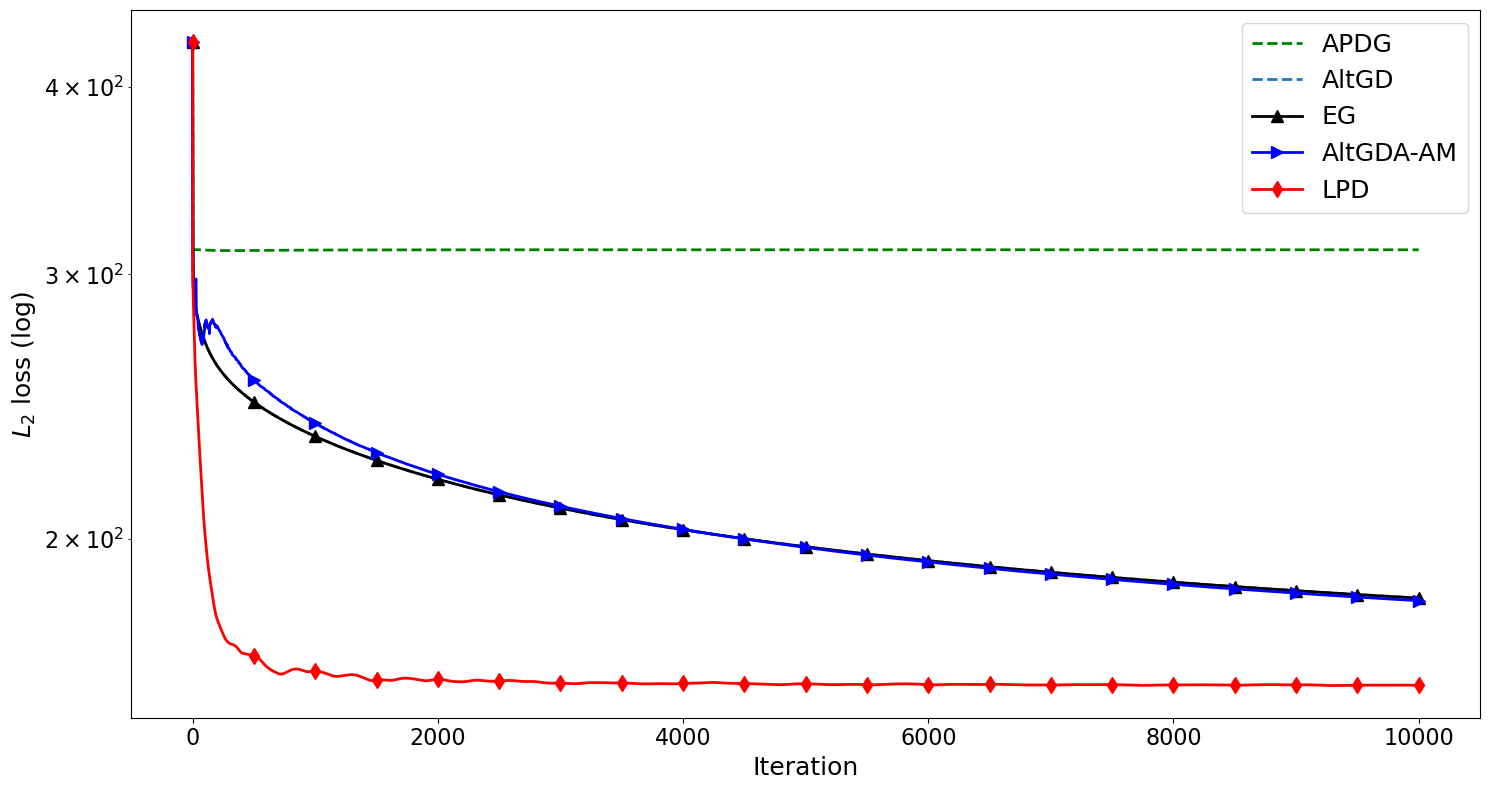

In [59]:
%matplotlib inline
plot_interval = 1
markevery=500
for method in methods_dict_4:
    if method not in ["OMD", "SimGD"]:
        plt.semilogy(np.arange(0, len(methods_dict_4[method]["loss_hist"])+plot_interval-1, plot_interval),
                     methods_dict_4[method]["loss_hist"][::plot_interval],
                     methods_dict_4[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel(r"$L_2$ loss (log)")
plt.legend()
plt.tight_layout()

APDG 157.43732612510152
AltGD 157.43732612510152
EG 157.43732612510152
AltGDA-AM 157.43732612510152
LPD 157.43732612510152


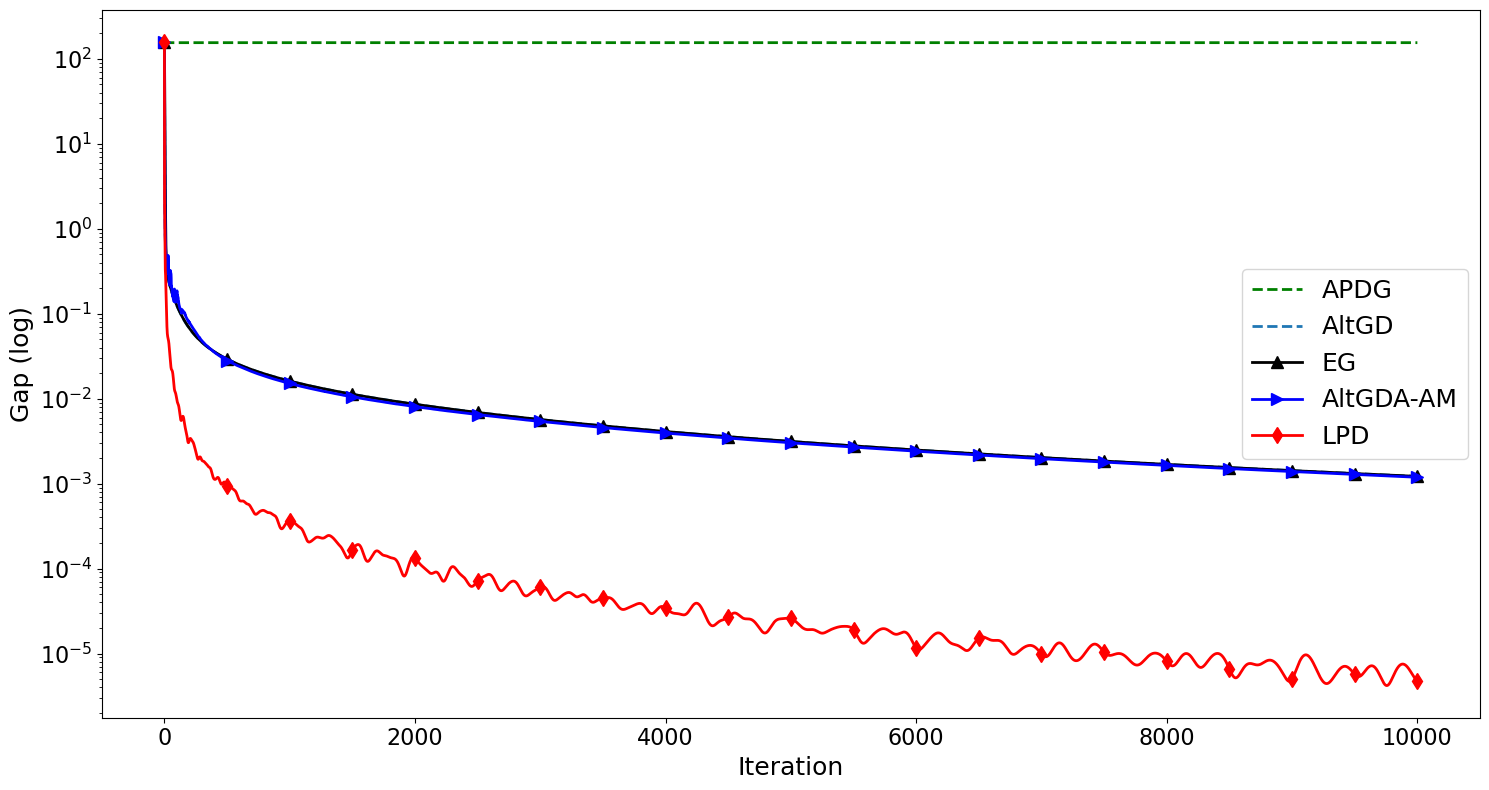

In [61]:
plot_interval = 1
markevery=500
for method in methods_dict_4:
    if method not in ["OMD", "SimGD"]:
        _gap =methods_dict_4[method]["class"].all_metrics["gap"]
        print(method, _gap[0])
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict_4[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"SC_C_MountainCar_gap_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"SC_C_MountainCar_gap_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

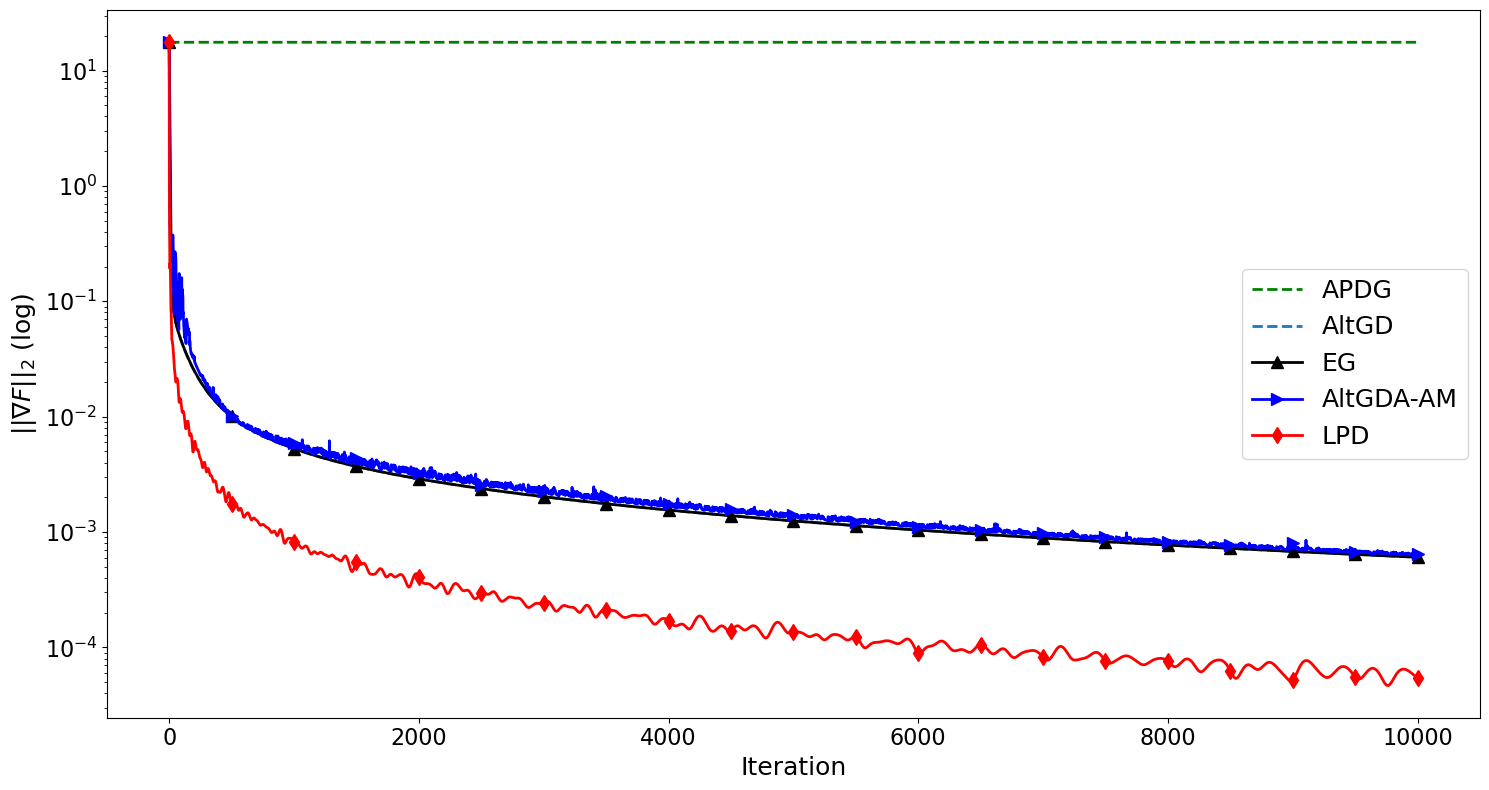

In [62]:
plot_interval = 1
markevery=500
for method in methods_dict_4:
    if method not in ["OMD", "SimGD"]:
        _gap =methods_dict_4[method]["class"].all_metrics["grad_norm"]
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict_4[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel(r"$||\nabla F||_2$ (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"SC_C_MountainCar_grad_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.jpg"))
plt.savefig(os.path.join("..", "figures", f"SC_C_MountainCar_grad_iter{iteration}_rho{RHO}_s{n}_a{n_a}_d{n_feat}.pdf"))

**OMD and SimGD simply diverged**